# Transfer learning

V tomto notebooku si ukážeme, jak velmi jednoduše použít předefinované a předtrénované modely v knihovně PyTorch pro rozpoznávání na CIFARu. Připomeňme si, že technika transfer learningu spočívá ve využití modelů, jenž byly optimalizovány na jinou úlohu než tu, kterou řešíme. Můžeme tedy např. vzít neurosíť naučenou klasifikovat obrázky z databáze ImageNet do jedné z jejích 1000 předdefinovaných tříd a přizpůsobit si ji pro klasifikaci CIFAR-10. Volba ImageNet není náhodná a pro transfer learning se používá velmi často, protože se jedná o jeden z nejrozsáhlejších volně dostupných datasetů.

Jelikož je většina kódu stejná v minulých úlohách, komentář bude přiložen pouze k relevantním sekcím.

**Pozn.:** K trénování složitejších modelů, mezi které patří i nejmenší ResNet, je zapotřebí GPU alespoň střední třídy. Na GTX1070 8GB trvá modelu resnet18 jedna CIFAR-10 epocha cca 7 min. CPU i7-2600K 3.4 GHz to v PyTorch zabere 6 hodin. Ve zjednodušeném módu trénování pouze poslední vsrtvy pak asi 2-3 hod. Vše testováno na Windows buildu PyTorch.

In [1]:
import cv2
import inspect
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tqdm

from IPython.core.debugger import set_trace

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import models
from torchvision import transforms

USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

## Data

In [3]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True)

X_train = trainset.train_data
y_train = np.array(trainset.train_labels, dtype=np.int64)
X_test = testset.test_data
y_test = np.array(testset.test_labels, dtype=np.int64)

print(type(X_train), X_train.shape, X_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)
print(type(X_test), X_test.shape, X_test.dtype)
print(type(y_test), y_test.shape, y_test.dtype)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_train, num_test = X_train.shape[0], X_train.shape[0]
x_dim = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]

Files already downloaded and verified
Files already downloaded and verified
<class 'numpy.ndarray'> (50000, 32, 32, 3) uint8
<class 'numpy.ndarray'> (50000,) int64
<class 'numpy.ndarray'> (10000, 32, 32, 3) uint8
<class 'numpy.ndarray'> (10000,) int64


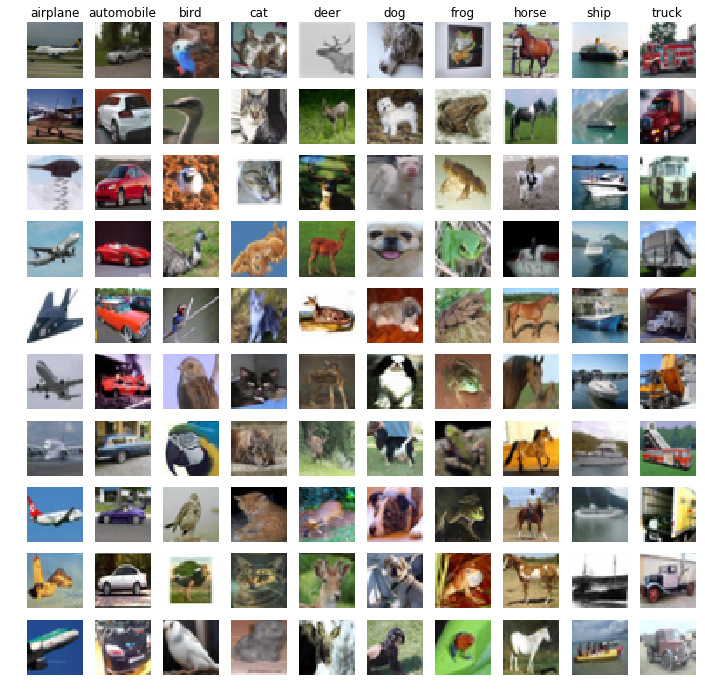

In [4]:
plt.figure(figsize=(12, 12))
for i, cls in enumerate(classes):
    cls_ids, = np.where(y_train == i)
    draw_ids = np.random.choice(cls_ids, size=10)
    
    for j, k in enumerate(draw_ids):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(X_train[k])
        plt.axis('off')
        if j == 0:
            plt.title(cls)
plt.show()

## Pomocné funkce

Jedna ze změn oproti vlastním modelům je nutnost přizpůsobit preprocessing dat. Pokud chceme použít předtrénovaný model, musíme zachovat charakter dat, na kterých byla síť natrénována. Jakýmsi "legacy" standardem přeživším ještě z dob AlexNetu, je trénování na obrázcích o rozměrech 224×224 pixelů a odečtením RGB vektoru (123.68, 116.779, 103.939) od každého pixelu. Vektor je průměrným pixelem spočteným na celém ImageNetu-2012.

*Pozn*.: Velikost obrázku musí být dodržena pouze kvůli lineárním vrstvám na vrchu sítě. Zatímco konvoluce jako taková může mít vstup i výstup o libovolných rozměrech, jedná se přece jen o posun nějakého filtru po obrázku, lineární vrstva předpokládá na vstupu vektor o fixní velikosti a rovněž pak produkuje výstup o definovaném rozměru. Poslední klasifikační vrstva, která je lineární, poslední konvoluční mapu "zploští" do vektoru a pokud by měla pokaždé jinou velikost, měnila by se dimenze vektoru.

In [5]:
def preprocess_pretrained(rgb_batch):
    rgb_batch = [cv2.resize(rgb, (224, 224), -1, 0., 0., cv2.INTER_LANCZOS4) for rgb in rgb_batch]
    X = np.array(rgb_batch, dtype=np.float32)
    
    # v PyTorchi vsechny predtrenovane modely ocekavaji vstup v rozsahu 0..255
    # a s odectenym prumernym RGB pixelem (123.68, 116.779, 103.939) - hodnoty byly zjisteny
    # zprumerovanim ImageNetu
    X -= np.array([123.68, 116.779, 103.939])
    
    # pracujeme s obrazky --> je nutne transponovat na torch format
    X = X.transpose(0, 3, 1, 2)
    
    return X

In [6]:
def train(model, loss_func, optimizer, X_data, y_data, prep_fn=None, batch_size=20, history_output=None, num_iters=None,
          permute=True):
    model.train()
    
    if isinstance(history_output, list):
        history_output.append({'loss': [], 'acc': []})
        
    if permute:
        perm = np.random.permutation(X_data.shape[0])
    else:
        perm = np.arange(X_data.shape[0], dtype=np.int)
       
    if num_iters is None:
        num_iters = int(np.ceil(X_data.shape[0] / batch_size))
        
    forget = 0.98
    mean_loss = 0.
    mean_acc = 0.
    
    pb = tqdm.trange(num_iters, desc='train')
    for n in pb:
        # stejne jako minule navzorkujeme data
        batch_ids = perm[n * batch_size:(n + 1) * batch_size]
        x = X_data[batch_ids]
        if prep_fn is not None:
            x = prep_fn(x)
        y = y_data[batch_ids]
        
        x = Variable(torch.from_numpy(x))
        y = Variable(torch.from_numpy(y))
        
        if USE_CUDA:
            x, y = x.cuda(), y.cuda()
        
        # dopredny pruchod
        score = model(x)
        
        # loss
        loss = loss_func(score, y)
        mean_loss = (forget * mean_loss + (1. - forget) * float(loss)) if mean_loss is not None else float(loss)
        
        # zpetny pruchod = vypocet gradientu; pred samotnym vypoctem je nutne manualne
        # vynulovat gradienty z predchozi iterace, jinak by se vypoctene gradienty pouze
        # pricetly k minulym
        optimizer.zero_grad()
        loss.backward()
        
        # update parametru
        optimizer.step()
        
        # spocitat statistiky
        _, pred = score.data.max(dim=1)
        num_correct = torch.sum(pred == y.data)
        acc = num_correct / x.shape[0]
        mean_acc = (0.95 * mean_acc + 0.05 * acc) if mean_acc is not None else acc
        
        if isinstance(history_output, list):
            history_output[-1]['loss'].append(float(loss))
            history_output[-1]['acc'].append(acc)
        
        pb.set_postfix(loss='{:.3f}'.format(mean_loss), acc='{:.3f}'.format(mean_acc))
    
    print('train loss={:.3f}, acc={:.3f}'.format(mean_loss, mean_acc))

In [7]:
def validate(model, loss_func, X_data, y_data, prep_fn=None, batch_size=20, history_output=None):
    model.eval()
    
    if isinstance(history_output, list):
        history_output[-1].update({'val_loss': [], 'val_acc': []})
    
    num_iters = int(np.ceil(X_data.shape[0] / batch_size))
    
    total_loss = 0.
    total_acc = 0.
    
    pb = tqdm.trange(num_iters, desc='val')
    for n in pb:
        batch_ids = np.arange(n * batch_size, (n + 1) * batch_size)
        x = X_data[batch_ids]
        if prep_fn is not None:
            x = prep_fn(x)
        y = y_data[batch_ids]
        
        x = Variable(torch.from_numpy(x))
        y = Variable(torch.from_numpy(y))
        
        if USE_CUDA:
            x, y = x.cuda(), y.cuda()
        
        # dopredny pruchod
        score = model(x)
        
        # loss
        loss = loss_func(score, y)
        total_loss += float(loss)
        
        # spocitat statistiky
        _, pred = score.data.max(dim=1)
        num_correct = torch.sum(pred == y.data)
        acc = num_correct / x.shape[0]
        total_acc += acc
        
        if isinstance(history_output, list):
            history_output[-1]['val_loss'].append(float(loss))
            history_output[-1]['val_acc'].append(acc)
        
        pb.set_postfix(loss='{:.3f}'.format(total_loss / (n + 1)), acc='{:.3f}'.format(total_acc / (n + 1)))
    
    print('val loss={:.3f}, acc={:.3f}'.format(total_loss / (n + 1), total_acc / (n + 1)))

In [8]:
def plot_history(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plt.figure(figsize=(10, 3))
    for mi, metric in enumerate(('loss', 'acc')):
        plt.subplot(1, 2, mi + 1)
        
        last = 0.
        trn_data, val_data = [], []
        for h in history:
            trn_data.append(np.mean(h[metric]))
            val_data.append(np.mean(h['val_' + metric]) if h.get('val_' + metric) else last)
            last = val_data[-1]
        
        plt.plot(trn_data)
        line, = plt.plot(val_data)
        
        best = np.argmax(val_data) if metric == 'acc' else np.argmin(val_data)
        plt.plot([best], [val_data[best]], 'o', color=line.get_color())
        plt.text(best - 0.75, val_data[best] + 0.01, '{:.3f}'.format(val_data[best]), color=line.get_color())
        
        plt.ylabel(metric)
    
    plt.show()

## Předtrénovaný model

Předtrénované modely jsou schované v modulu `torchvision.models`. Pokud chceme síť již inicializovanou váhami naučenými na ImageNetu, zadáme keyword argument `pretrained` jako `True`. Zde si zkusíme nejmenší dostupnou variantu ResNetu (viz přednáška 4) s 18 vrstvami (konvoluce a lineární).

In [9]:
resnet = models.resnet18(pretrained=True)
resnet_history = []

In [10]:
resnet

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

Všimněme si, jak vypadá dopředný průchod (vyskočí okno s kódem):

In [11]:
??resnet.forward

### Zmrazení konvolučních vrstev (layer freezing)

Váhy konvolučních filtrů přetrénované sítě byly odladěny pro úlohu klasifikace na ImageNetu. V jednotlivých vrstvách vytvářejí příznaky, které se ukázaly jako optimální v této poměrně složité úloze. Jelikož se CIFAR od ImageNetu charakterem obrázků zase tolik neliší, je velmi pravděpodobné, že příznaky budou fungovat i v naší úloze. Pokud bychom měli menší dataset, relativní velikostí a "silou" modelu by mohlo rychle dojít k přeučení a následnému poklesu klasifikačního skóre. CIFAR však obsahuje 50000 trénovacích obrázků, a tak následující kód pro zablokování výpočtu gradientů u zvolených vrstev není nutný.



### Nahrazení vrchní vrstvy

Přizpůsobení naší sítě bude spočívat pouze v nahrazení poslední klasifikační vrstvy, která se u `ResNet` sítí v PyTorchi jmenuje `fc`, jinou lineární vrstvou s pouze 10 výstupy pro našich 10 tříd.

In [12]:
resnet.fc = nn.Linear(512, 10)

Poslední klasifikační vrstva by se samozřejmě měla trénovat vždy. Zkontrolujeme:

In [13]:
resnet.fc.weight.requires_grad, resnet.fc.bias.requires_grad

(True, True)

In [14]:
if USE_CUDA:
    resnet.cuda()

### Trénování

In [15]:
loss = nn.CrossEntropyLoss()

Pokud budeme učit celou síť, zadáme do našeho optimizeru seznam všech parametrů sítě, tj. `resnet.parameters()`. Pokud bychom zmrazili učení všech vrstev kromě poslední, zadali bychom `resnet.fc.parameters()`.

In [16]:
resnet_optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-3)

Ukážeme si i postupné snižování learning rate. V PyTorch tuto funkcionalitu zajišťuje modul `torch.optim.lr_scheduler`. Objekt se obsluhuje podobně jako optimizer, tj. metodou `step`, kterou musíme manuálně zavolat každou "epochu", nebo zkrátka interval, po kterém chceme learning rate změnit.

Learning rate bychom mohli např. na polovinu zmenšit i ručně: `resnet_optimizer.param_groups()[0]['lr'] *= 0.5`. Výhodou objektů typu `torch.optim.lr_scheduler._LRScheduler` je ale možnost použít i mnohem složitější pravidla, např. cyklickou změnu learning rate.

In [17]:
# kazdou epochu (druhy parametr 1) zmensime learning rate na polovinu
# parametr `last_epoch` udava minulou epochu; na zacatku tedy -1
resnet_scheduler = optim.lr_scheduler.StepLR(resnet_optimizer, 1, gamma=0.5, last_epoch=-1)

#### Ukládání modelu (checkpoint)

Objekty v PyTorchi jako modely a další mají svůj `state_dict`, který kompletně popisuje jejich aktuální stav. Např. síť zde bude mít váhy filtrů a biasů, optimizer kromě svých parametrů i současné vektory momentu hybnosti atd.

**Pozn.:** Pokud budete využívat Google Colaboratory, hlídejte si místo na disku. Některé modely jako VGG vyžadují i 1 GB na uložení, především pokud ukládáte celé checkpointy včetně optimizeru či historie, které umožňují kdykoliv navázat na trénování.

In [18]:
def save_checkpoint(filename, model, optimizer, history):
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'history': history,
    }
    torch.save(checkpoint, filename)
    filesize = os.path.getsize(filename) / 1024 ** 2
    print('Model saved to {} ({:.1f} MB)'.format(filename, filesize))

In [19]:
%%time
for ep in range(10):
    # `scheduler` je potreba zavolat manualne
    resnet_scheduler.step()
    train(resnet, loss, resnet_optimizer, X_train, y_train, prep_fn=preprocess_pretrained, history_output=resnet_history)
    validate(resnet, loss, X_test, y_test, prep_fn=preprocess_pretrained, history_output=resnet_history)
    save_checkpoint('resnet18-pretrained-wd=1e-3-ep{:02d}.pth'.format(ep + 1), resnet, resnet_optimizer, resnet_history)

val:   1%|          | 3/500 [00:00<00:30, 16.14it/s, acc=0.937, loss=0.202]

train loss=0.248, acc=0.916


val: 100%|██████████| 500/500 [00:24<00:00, 20.72it/s, acc=0.928, loss=0.215]


val loss=0.215, acc=0.928


train:   0%|          | 2/2500 [00:00<03:23, 12.26it/s, acc=0.090, loss=0.008]

Model saved to resnet18-pretrained-wd=1e-3-ep01.pth (128.1 MB)


val:   1%|          | 3/500 [00:00<00:30, 16.04it/s, acc=0.938, loss=0.241]

train loss=0.125, acc=0.955


train:   0%|          | 0/2500 [00:00<?, ?it/s]

val loss=0.154, acc=0.948
Model saved to resnet18-pretrained-wd=1e-3-ep02.pth (128.1 MB)


val:   1%|          | 3/500 [00:00<00:32, 15.49it/s, acc=0.950, loss=0.180]

train loss=0.034, acc=0.994


val: 100%|██████████| 500/500 [00:23<00:00, 21.02it/s, acc=0.955, loss=0.136]


val loss=0.136, acc=0.955


train:   0%|          | 2/2500 [00:00<03:22, 12.33it/s, acc=0.098, loss=0.000]

Model saved to resnet18-pretrained-wd=1e-3-ep03.pth (128.2 MB)


val:   1%|          | 3/500 [00:00<00:30, 16.52it/s, acc=0.950, loss=0.233]

train loss=0.015, acc=0.998


val: 100%|██████████| 500/500 [00:24<00:00, 20.75it/s, acc=0.960, loss=0.128]


val loss=0.128, acc=0.960


train:   0%|          | 2/2500 [00:00<03:18, 12.58it/s, acc=0.098, loss=0.000]

Model saved to resnet18-pretrained-wd=1e-3-ep04.pth (128.2 MB)


val:   1%|          | 3/500 [00:00<00:30, 16.27it/s, acc=0.938, loss=0.202]

train loss=0.010, acc=0.998


val: 100%|██████████| 500/500 [00:24<00:00, 20.83it/s, acc=0.960, loss=0.123]


val loss=0.123, acc=0.960


train:   0%|          | 2/2500 [00:00<03:17, 12.63it/s, acc=0.098, loss=0.000]

Model saved to resnet18-pretrained-wd=1e-3-ep05.pth (128.3 MB)


val:   1%|          | 3/500 [00:00<00:29, 16.66it/s, acc=0.962, loss=0.208]

train loss=0.008, acc=0.998


val: 100%|██████████| 500/500 [00:23<00:00, 20.86it/s, acc=0.963, loss=0.123]


val loss=0.123, acc=0.963


train:   0%|          | 2/2500 [00:00<03:19, 12.50it/s, acc=0.098, loss=0.000]

Model saved to resnet18-pretrained-wd=1e-3-ep06.pth (128.3 MB)


val:   1%|          | 3/500 [00:00<00:30, 16.17it/s, acc=0.938, loss=0.198]

train loss=0.007, acc=0.999


val: 100%|██████████| 500/500 [00:23<00:00, 20.89it/s, acc=0.962, loss=0.121]


val loss=0.121, acc=0.962


train:   0%|          | 2/2500 [00:00<03:29, 11.93it/s, acc=0.098, loss=0.000]

Model saved to resnet18-pretrained-wd=1e-3-ep07.pth (128.4 MB)


val:   1%|          | 3/500 [00:00<00:30, 16.41it/s, acc=0.950, loss=0.215]

train loss=0.006, acc=0.999


val: 100%|██████████| 500/500 [00:23<00:00, 20.99it/s, acc=0.961, loss=0.125]


val loss=0.125, acc=0.961


train:   0%|          | 2/2500 [00:00<03:27, 12.03it/s, acc=0.098, loss=0.000]

Model saved to resnet18-pretrained-wd=1e-3-ep08.pth (128.4 MB)


val:   1%|          | 3/500 [00:00<00:28, 17.26it/s, acc=0.975, loss=0.197]

train loss=0.005, acc=1.000


train:   0%|          | 0/2500 [00:00<?, ?it/s]

val loss=0.119, acc=0.964
Model saved to resnet18-pretrained-wd=1e-3-ep09.pth (128.5 MB)


val:   1%|          | 3/500 [00:00<00:30, 16.23it/s, acc=0.950, loss=0.212]

train loss=0.006, acc=1.000


val: 100%|██████████| 500/500 [00:23<00:00, 20.87it/s, acc=0.963, loss=0.120]


val loss=0.120, acc=0.963
Model saved to resnet18-pretrained-wd=1e-3-ep10.pth (128.5 MB)
CPU times: user 31min 20s, sys: 4min 32s, total: 35min 52s
Wall time: 34min 58s


**Pozn.:** časy, které vidíte ve výstupu předchozího bloku, byly dosaženy na GTX1080 Ti 12GB.

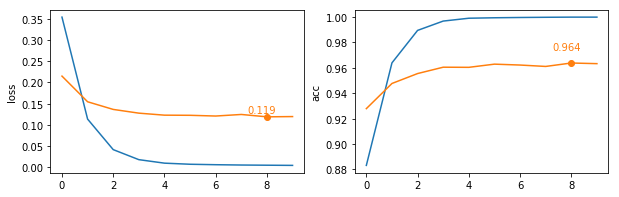

In [20]:
plot_history(resnet_history)

## Jiný model

In [21]:
vgg = models.vgg11_bn(pretrained=True)
vgg_history = []

In [22]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU(inplace)
    (11): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (15): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): BatchNo

Jak vidíme, poslední vrstva ve VGG modelech má jiný název. Vyměníme ji tedy následovně:

In [23]:
vgg.classifier._modules['6'] = nn.Linear(4096, 10)

In [24]:
if USE_CUDA:
    vgg.cuda()

In [25]:
vgg_optimizer = optim.Adam(vgg.parameters(), lr=1e-4, weight_decay=1e-3)
vgg_scheduler = optim.lr_scheduler.StepLR(vgg_optimizer, 1, gamma=0.5, last_epoch=-1)

In [26]:
%%time
for ep in range(10):
    # `scheduler` je potreba zavolat manualne
    vgg_scheduler.step()
    train(vgg, loss, vgg_optimizer, X_train, y_train, prep_fn=preprocess_pretrained, history_output=vgg_history)
    validate(vgg, loss, X_test, y_test, prep_fn=preprocess_pretrained, history_output=vgg_history)
    save_checkpoint('vgg11_bn-pretrained-wd=1e-3-ep{:02d}.pth'.format(ep + 1), vgg, vgg_optimizer, vgg_history)

val:   0%|          | 2/500 [00:00<00:33, 14.80it/s, acc=1.000, loss=0.097]

train loss=0.293, acc=0.903


val: 100%|██████████| 500/500 [00:33<00:00, 14.88it/s, acc=0.902, loss=0.299]


val loss=0.299, acc=0.902


train:   0%|          | 1/2500 [00:00<08:05,  5.15it/s, acc=0.048, loss=0.002]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep01.pth (1474.2 MB)


val:   0%|          | 2/500 [00:00<00:34, 14.55it/s, acc=0.950, loss=0.311]

train loss=0.140, acc=0.940


val: 100%|██████████| 500/500 [00:33<00:00, 14.86it/s, acc=0.932, loss=0.211]


val loss=0.211, acc=0.932


train:   0%|          | 1/2500 [00:00<08:10,  5.09it/s, acc=0.048, loss=0.004]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep02.pth (1474.3 MB)


val:   0%|          | 2/500 [00:00<00:33, 14.94it/s, acc=0.975, loss=0.186]

train loss=0.040, acc=0.989


val: 100%|██████████| 500/500 [00:33<00:00, 14.83it/s, acc=0.936, loss=0.225]


val loss=0.225, acc=0.936


train:   0%|          | 1/2500 [00:00<08:05,  5.14it/s, acc=0.050, loss=0.000]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep03.pth (1474.3 MB)


val:   0%|          | 2/500 [00:00<00:33, 14.79it/s, acc=0.950, loss=0.223]

train loss=0.021, acc=0.995


val: 100%|██████████| 500/500 [00:33<00:00, 14.80it/s, acc=0.942, loss=0.217]


val loss=0.217, acc=0.942


train:   0%|          | 0/2500 [00:00<?, ?it/s]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep04.pth (1474.4 MB)


val:   0%|          | 2/500 [00:00<00:33, 14.67it/s, acc=0.975, loss=0.226]

train loss=0.009, acc=0.998


val: 100%|██████████| 500/500 [00:34<00:00, 14.65it/s, acc=0.943, loss=0.210]


val loss=0.210, acc=0.943


train:   0%|          | 0/2500 [00:00<?, ?it/s]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep05.pth (1474.4 MB)


val:   0%|          | 2/500 [00:00<00:33, 14.67it/s, acc=0.950, loss=0.318]

train loss=0.005, acc=1.000


val: 100%|██████████| 500/500 [00:34<00:00, 14.55it/s, acc=0.944, loss=0.216]


val loss=0.216, acc=0.944


train:   0%|          | 1/2500 [00:00<08:10,  5.09it/s, acc=0.050, loss=0.000]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep06.pth (1474.5 MB)


val:   0%|          | 2/500 [00:00<00:36, 13.76it/s, acc=0.925, loss=0.356]

train loss=0.003, acc=1.000


val: 100%|██████████| 500/500 [00:34<00:00, 14.64it/s, acc=0.943, loss=0.220]


val loss=0.220, acc=0.943


train:   0%|          | 0/2500 [00:00<?, ?it/s]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep07.pth (1474.5 MB)


val:   0%|          | 2/500 [00:00<00:33, 14.67it/s, acc=0.975, loss=0.304]

train loss=0.003, acc=1.000


val: 100%|██████████| 500/500 [00:34<00:00, 14.61it/s, acc=0.946, loss=0.213]


val loss=0.213, acc=0.946


train:   0%|          | 0/2500 [00:00<?, ?it/s]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep08.pth (1474.6 MB)


val:   0%|          | 2/500 [00:00<00:33, 14.68it/s, acc=0.975, loss=0.306]

train loss=0.002, acc=1.000


val: 100%|██████████| 500/500 [00:34<00:00, 14.51it/s, acc=0.945, loss=0.213]


val loss=0.213, acc=0.945


train:   0%|          | 1/2500 [00:00<08:06,  5.13it/s, acc=0.050, loss=0.000]

Model saved to vgg11_bn-pretrained-wd=1e-3-ep09.pth (1474.6 MB)


val:   0%|          | 2/500 [00:00<00:34, 14.62it/s, acc=0.950, loss=0.322]

train loss=0.003, acc=0.999


val: 100%|██████████| 500/500 [00:34<00:00, 14.61it/s, acc=0.945, loss=0.213]


val loss=0.213, acc=0.945
Model saved to vgg11_bn-pretrained-wd=1e-3-ep10.pth (1474.7 MB)
CPU times: user 1h 50s, sys: 21min 56s, total: 1h 22min 47s
Wall time: 1h 22min 31s


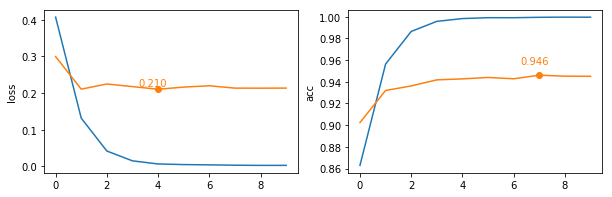

In [27]:
plot_history(vgg_history)

## Kombinace více modelů (ensemble)

In [28]:
class Ensemble(nn.Module):
    def __init__(self, *models):
        super().__init__()
        self.models = models
        
        # toto je potreba kvuli spravnemu nastaveni eval modu
        for i, m in enumerate(self.models):
            self.add_module(str(i), m)
        
        if USE_CUDA:
            for m in self.models:
                m.cuda()
    
    def forward(self, x):
        scores = [m(x) for m in self.models]
        return torch.mean(torch.stack(scores), 0)

In [60]:
nets = []

In [61]:
checkpoint = torch.load('resnet18-pretrained-wd=1e-3-ep09.pth')

tmp = models.resnet18(pretrained=False)
tmp.fc = nn.Linear(512, 10)
tmp.load_state_dict(checkpoint['model'])

nets.append(tmp)

In [62]:
checkpoint = torch.load('vgg11_bn-pretrained-wd=1e-3-ep07.pth')

tmp = models.vgg11_bn(pretrained=True)
tmp.classifier._modules['6'] = nn.Linear(4096, 10)
tmp.load_state_dict(checkpoint['model'])

nets.append(tmp)

In [63]:
ensemble = Ensemble(*nets)

In [64]:
ensemble.eval()

Ensemble(
  (0): ResNet(
    (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1

In [65]:
assert all(not m.training for m in ensemble.models)

In [66]:
validate(ensemble, loss, X_test, y_test, prep_fn=preprocess_pretrained)

val: 100%|██████████| 500/500 [00:38<00:00, 13.06it/s, acc=0.964, loss=0.125]

val loss=0.125, acc=0.964


Jak vidíme, kombinace více modelů v tomto případě nepomohla. Modely by měly být dostatečně odlišné a blízké svojí úspěšností, coz zřejmě v našem případě neplatí. Dosáhli jsme tedy nakonec **skóre 96.4 %**. Pro srovnání, state of the art (stav poznání) dosažený pomocí jednoho modelu na datasetu CIFAR-10 je 97.69% (ResNetXt). Detaily je možné v článku [ShakeDrop regularization](https://openreview.net/pdf?id=S1NHaMW0b). Rozdíl se může zdát malý, ovšem u takovýchto vysokých skóre je vhodnější sledovat spíše chybovost, tj. 100 - úspěšnost. Rozdíl pak je 3.6 % vs 2.31 %, stále tedy ještě docela velký kus cesty.

## Pro zábavu

1. Porovnejte úspěšnost při zablokovaném/odblokovaném učení konvolučních vrstev.
2. Zkuste stejnou síť natrénovat "from scratch", tj. bez využití předtrénovaných vah. Jak se trénování změní, když tak učiníte?
3. Vyzkoušejte si i jiné sítě než ResNet či VGG. Fungují stejně dobře?
4. Pokuste se ještě vylepšit skóre a co nejvíce se přiblížit, či nejlépe překonat, state of the art. Mohla by pomoci např. augmentace dat nebo jiné techniky regulace learning rate.